In [2]:
import sys
sys.path.append('..')

In [3]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from DomainPrediction import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign

In [5]:
root = '../..'
data_path = os.path.join(root, 'Data/')

In [6]:
## Read Protein
protein = BaseProtein(file=os.path.join(data_path, 'GxpS_ATC_AF.pdb'))
A = [i for i in range(33,522)] ## 34-522
C = [i for i in range(637,1067)] ## 638-1067
T = [i for i in range(538, 608)] ## 539-608

In [7]:
protein.get_residues(T) ## Get domains - Here T

'GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'

In [8]:
## Compute Seq ID after aligning to WT
wt = os.path.join(data_path, 'GxpS.T.fasta')
gen = os.path.join(data_path, 'evodiff_experiments/evodiff_100.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
seq_ids = metrics.compute_sequence_identity(wt, gen, hmm=pfam_T_hmm)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 65.26it/s]


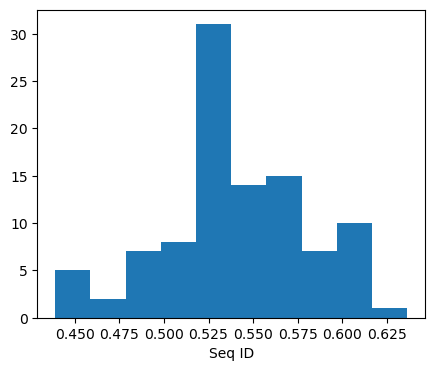

In [9]:
_ = plt.figure(figsize=(5,4))
_ = plt.hist(seq_ids)
_ = plt.xlabel('Seq ID')

In [10]:
## % of sequences that contain the motif FF__GG_S
gen = os.path.join(data_path, 'evodiff_experiments/evodiff_100.T.fasta')
metrics.search_and_filter_motif(gen)

100.0% records contain motif


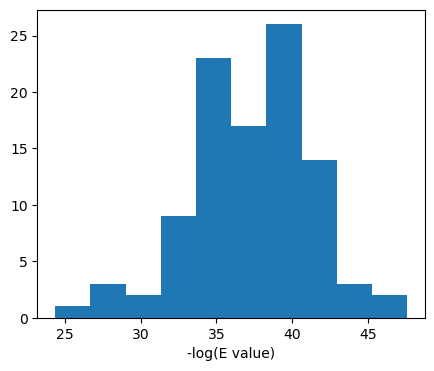

In [11]:
## Get dataframme from HMM search
hmmer = HmmerTools()

gen = os.path.join(data_path, 'evodiff_experiments/evodiff_100.T.fasta')
pfam_T_hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
df = hmmer.hmmsearch(hmm_path=pfam_T_hmm, fasta_file=gen)

_ = plt.figure(figsize=(5,4))
_ = plt.hist(-np.log(df['Evalue']))
_ = plt.xlabel('-log(E value)')

In [12]:
esm_save_path = os.path.join(data_path, 'esm_experiments/gen_1000/pdbs_GxpS_ATC')
evodiff_save_path = os.path.join(data_path, 'evodiff_experiments/pdbs_ATC')

In [17]:
folded_proteins_esm = []
for i in range(100):
    f = f'GxpS_ATC-temp_0.5-gen_{i}.pdb'
    file = os.path.join(esm_save_path, f)
    assert os.path.isfile(file)
    if f.endswith('.pdb'):
        folded_proteins_esm.append(FoldedProtein(file, id=f.replace('.pdb', '')))

In [19]:
folded_proteins_esm[0].metadata

{'predicted_aligned_error': array([[ 0.2501439 ,  2.0019798 ,  4.272129  , ..., 29.437294  ,
         29.915167  , 29.893688  ],
        [ 1.5248691 ,  0.25001344,  1.6932259 , ..., 29.24406   ,
         29.801058  , 29.741367  ],
        [ 3.1743202 ,  1.32255   ,  0.2500005 , ..., 29.05364   ,
         29.584597  , 29.752308  ],
        ...,
        [29.04523   , 29.220627  , 28.838455  , ...,  0.25000408,
          1.1810107 ,  2.75421   ],
        [28.642742  , 28.768688  , 28.536957  , ...,  1.4457289 ,
          0.25001234,  1.2281322 ],
        [28.898102  , 28.98161   , 28.691576  , ...,  3.2959013 ,
          1.664209  ,  0.25121516]], dtype=float32),
 'ptm': array(0.5583875, dtype=float32),
 'EFtm_rmsd': array(5.8),
 'EFtm_seq_id': array(0.733),
 'EFtm_score': array(0.6243),
 'AF_tm_rmsd': array(2.19),
 'AF_tm_seq_id': array(0.938),
 'AF_tm_score': array(0.42306),
 'esm2_650M_perplexity': array(4.59600543)}

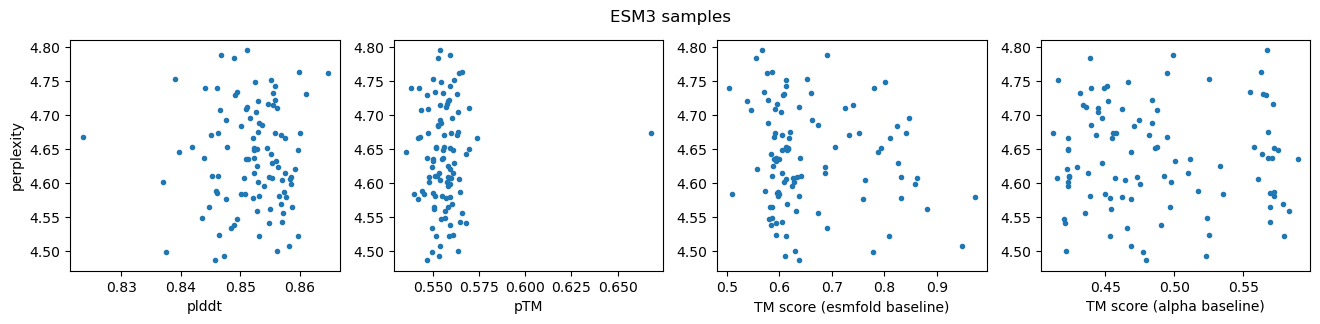

In [37]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
fig.suptitle('ESM3 samples')
_ = ax[0].scatter([f.plddt for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.')
_ = ax[0].set_ylabel('perplexity')
_ = ax[0].set_xlabel('plddt')
_ = ax[1].scatter([f.pTM for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.')
_ = ax[1].set_xlabel('pTM')
_ = ax[2].scatter([f.metadata['EFtm_score']  for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.')
_ = ax[2].set_xlabel('TM score (esmfold baseline)')
_ = ax[3].scatter([f.metadata['AF_tm_score']  for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.')
_ = ax[3].set_xlabel('TM score (alpha baseline)')

In [45]:
folded_proteins_evodiff = []
for i in range(50):
    f = f'EvoDiff_GxpS_ATC_gen_{i}.pdb'
    file = os.path.join(evodiff_save_path, f)
    assert os.path.isfile(file)
    if f.endswith('.pdb'):
        folded_proteins_evodiff.append(FoldedProtein(file, id=f.replace('.pdb', '')))

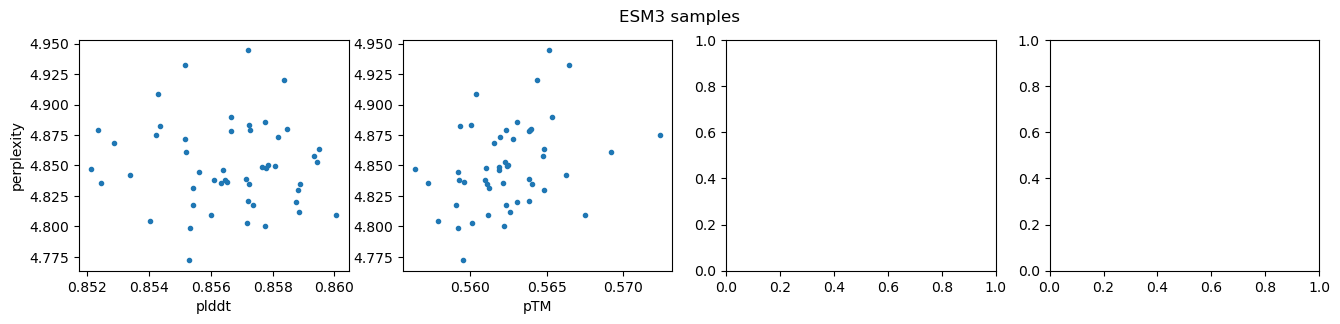

In [46]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
fig.suptitle('ESM3 samples')
_ = ax[0].scatter([f.plddt for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.')
_ = ax[0].set_ylabel('perplexity')
_ = ax[0].set_xlabel('plddt')
_ = ax[1].scatter([f.pTM for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.')
_ = ax[1].set_xlabel('pTM')
# _ = ax[2].scatter([f.metadata['EFtm_score']  for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.')
# _ = ax[2].set_xlabel('TM score (esmfold baseline)')
# _ = ax[3].scatter([f.metadata['AF_tm_score']  for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.')
# _ = ax[3].set_xlabel('TM score (alpha baseline)')

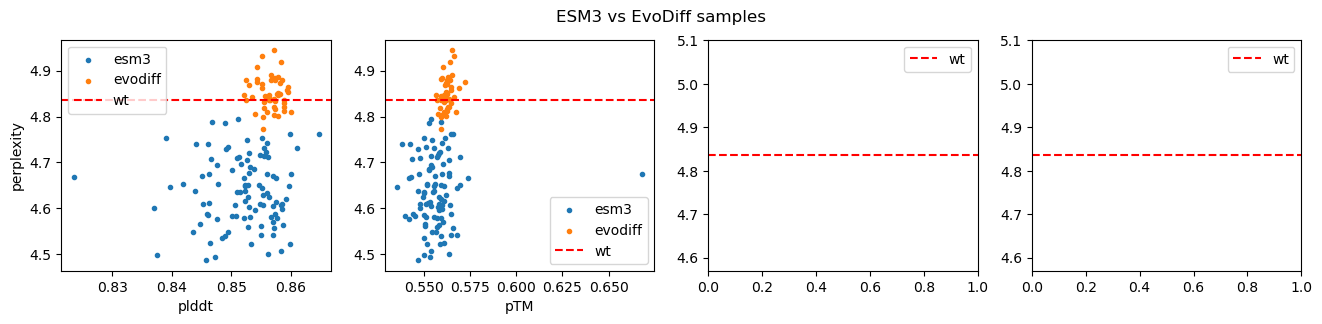

In [47]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
fig.suptitle('ESM3 vs EvoDiff samples')
_ = ax[0].scatter([f.plddt for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.', label='esm3')
_ = ax[0].scatter([f.plddt for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.', label='evodiff')
_ = ax[0].set_ylabel('perplexity')
_ = ax[0].set_xlabel('plddt')
_ = ax[1].scatter([f.pTM for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.', label='esm3')
_ = ax[1].scatter([f.pTM for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.', label='evodiff')
_ = ax[1].set_xlabel('pTM')
_ = ax[2].scatter([f.metadata['EFtm_score']  for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.', label='esm3')
_ = ax[2].scatter([f.metadata['EF_tm_score']  for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.', label='evodiff')
_ = ax[2].set_xlabel('TM score (esmfold baseline)')
_ = ax[3].scatter([f.metadata['AF_tm_score']  for f in folded_proteins_esm], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_esm], marker='.', label='esm3')
_ = ax[3].scatter([f.metadata['AF_tm_score']  for f in folded_proteins_evodiff], [f.metadata['esm2_650M_perplexity'] for f in folded_proteins_evodiff], marker='.', label='evodiff')
_ = ax[3].set_xlabel('TM score (alpha baseline)')

wt_perplexity = 4.835815952586172
_ = ax[0].axhline(wt_perplexity, linestyle='--', color='red', label='wt')
_ = ax[1].axhline(wt_perplexity, linestyle='--', color='red', label='wt')
_ = ax[2].axhline(wt_perplexity, linestyle='--', color='red', label='wt')
_ = ax[3].axhline(wt_perplexity, linestyle='--', color='red', label='wt')


_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[2].legend()
_ = ax[3].legend()

fig.savefig('samples.png') 